<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)</br>
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели каритнку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/iK9ZtggjJcGKIA)

### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота ))0))
5. Whatever comes to your head

## Базовая часть:

### 1. Предобработка текстов из датасета

In [3]:
DATA_PATH = ''
%matplotlib inline

# For Google Colab only:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/Final')
#from reco_utils.recommender.sar.sar_singlenode import SARSingleNode
from google.colab import drive
drive.mount('/content/gdrive')

#DATA_PATH = 'gdrive/My Drive/Colab Notebooks/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
%cd '/content/gdrive/My Drive/Colab Notebooks/Final'
%ls

/content/gdrive/My Drive/Colab Notebooks/Final
 beheaded_inception3.py   handout.tar              __pycache__/
 best_model_1.pt          image_captionong.ipynb  'Telegram bot'/
 coco_images.h5          'Imgs '/                  Ubuntu-Regular.ttf
 coco_img_arrays/         NNattention.jpg          vocab.npy
 data/                    NNBasestructure.png      words.txt


In [5]:
import numpy as np
import json

# загружаем датасет
img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

In [6]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлвх занятиях. Батч должен выглядеть примерно так:
ВАЖНО! Почему я советую писать отдельную функцию, которая генерирует батч: дело в том, что в датасете для каждой картинки есть несколько (5-7) различных описаний. Когда создаете батч, лучше, чтобы в нем были разные картинки, и к каждой картинке при создании батча выбирать одно из ее описаний рандомно. Это проще реализовать в отдельной функции (но вы, конечно, можете писать код как хотите)
5. Поделить выборку на train/test

[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезуются, в начале и конце по коду символа начал и конца предложения.

Уверена, эта часть вам покажется очень знакомой и легкой =)

In [7]:
class Vocabulary:
    def __init__(self, corpus, thr=5, trash_words=["..", "...", "\\", "`", ">"]):

        self.bos = '<bos>'
        self.eos = '<eos>'
        self.pad = '<pad>'

        words = [self.split_sentence(sent) for sent in corpus]
        # flatten the array
        words = [item for sent in words for item in sent]
        words = np.array(words)
        w, n = np.unique(words, return_counts=True)
        w = w[(n > thr) & ~np.isin(w, trash_words)]
        self.words = np.insert(w, 0, (self.bos, self.eos, self.pad))
        
        self.word2idx = dict(zip(self.words, range(self.words.size)))

    def load_dict(self, path):
        self.words = np.load(path)
        self.word2idx = dict(zip(self.words, range(self.words.size)))

    def save_dict(self, path):
        np.save(path, self.words)

    @staticmethod
    def split_sentence(sents):
        return [item for sent in sents for item in sent.split(' ')]

    def sent_to_idx(self, sent):
        return [self.word2idx[word] for word in sent]

    def idx_to_sent(self, sent):
        return [self.words[idx] for idx in sent]

In [8]:
vocab = Vocabulary(captions)
vocab.save_dict('vocab.npy')

In [9]:
vocab_test = Vocabulary(captions)
vocab_test.load_dict('vocab.npy')

In [10]:
vocab.words[150]

'advertisements'

In [11]:
vocab_test.words[150]

'advertisements'

In [12]:
len(vocab.words)

9505

In [13]:
from tqdm.notebook import tqdm

class Corpus:
    def __init__(self, corpus, vocab, max_len=15):
        splitted_text = []
        self.filtered_text = []
        self.indexed_text = []

        print('Splitting sentences:')
        for sents in tqdm(corpus):
            splitted_text.append([sent.split() for sent in sents])

        print('Filtering sentences:')
        for sents in tqdm(splitted_text):
            rm_unk_words = [[word for word in sent if word in vocab.word2idx] for sent in sents]
            self.filtered_text.append([
                ([vocab.bos] + sent + [vocab.eos] + [vocab.pad]*max_len)[0: max_len+3]
            for sent in rm_unk_words if len(sent) > 0])

        print('Applying word2idx')
        for sents in tqdm(self.filtered_text):
            self.indexed_text.append([
                [vocab.word2idx[word] for word in sent]
            for sent in sents])

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(img_codes, captions, test_size=0.2, random_state=112)

In [15]:
idx_text_train = Corpus(y_train, vocab)
idx_text_test  = Corpus(y_test, vocab)

Splitting sentences:


  0%|          | 0/94629 [00:00<?, ?it/s]

Filtering sentences:


  0%|          | 0/94629 [00:00<?, ?it/s]

Applying word2idx


  0%|          | 0/94629 [00:00<?, ?it/s]

Splitting sentences:


  0%|          | 0/23658 [00:00<?, ?it/s]

Filtering sentences:


  0%|          | 0/23658 [00:00<?, ?it/s]

Applying word2idx


  0%|          | 0/23658 [00:00<?, ?it/s]

In [16]:
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, img_embed, captions_idx):
        self.img_embed     = img_embed     #[num_img, embedding]
        self.captions_idx  = captions_idx  #[num_img, num_descriptions, sent_length]

    def __getitem__(self, idx):
        caption_idx = np.random.randint(0, len(self.captions_idx[idx]))
        return (self.img_embed[idx], np.array(self.captions_idx[idx][caption_idx]))

    def __len__(self):
        return len(self.captions_idx)

In [ ]:
ds_train = Dataset(X_train, idx_text_train.indexed_text)
ds_test  = Dataset(X_test,  idx_text_test.indexed_text)

dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size = 256)
dataloader_test  = torch.utils.data.DataLoader(ds_test,  batch_size = 256)

### 2. Напишем свою сетку из RNN для вывода описаний


Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [17]:
import torch.nn as nn
import torch.nn.functional as F

<p align="center">
<img src="https://live.staticflickr.com/65535/51876877412_9d994fd916_k.jpg" alt="drawing" width="700"/>
</p>

In [18]:
class CaptionNet(nn.Module):
    def __init__(self, vocab_size, emb_size, cnn_feature_size=2048, hidden_dim=500, num_layers=2):
        super(self.__class__, self).__init__()
        self.num_layers = num_layers

        # стандартная архитектура такой сети такая: 
        # 1. линейные слои для преобразования эмбеддиинга картинки в начальные состояния h0 и c0 LSTM-ки
        # 2. слой эмбедднга
        # 3. несколько LSTM слоев (для начала не берите больше двух, чтобы долго не ждать)
        # 4. линейный слой для получения логитов

        self.fc_h = nn.Linear(in_features  = cnn_feature_size,
                             out_features = hidden_dim)
        self.fc_c = nn.Linear(in_features  = cnn_feature_size,
                             out_features = hidden_dim)
        
        self.emb = nn.Embedding(num_embeddings = vocab_size, 
                                embedding_dim  = emb_size)
        self.dropout = nn.Dropout(0.1)
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            dropout=0.2)
        
        self.fc_out = nn.Linear(in_features = hidden_dim,
                                out_features = vocab_size)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержащий выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы [batch, sent_len]
        :returns: логиты для сгенерированного текста описания, shape: [sent_len, batch, vocab_size]

        Обратите внимание, что мы подаем сети на вход сразу все префиксы описания 
        и просим ее к каждому префиксу сгенерировать следующее слово!
        """
        
        # 1. инициализируем LSTM state
        # 2. применим слой эмбеддингов к image_vectors
        # 3. скормим LSTM captions_emb
        # 4. посчитаем логиты из выхода LSTM

        h_0 = torch.tanh(self.fc_h(image_vectors)).unsqueeze(0) # [1, batch, hidden_dim] 
        c_0 = torch.tanh(self.fc_c(image_vectors)).unsqueeze(0) # [1, batch, hidden_dim]
        # h_0, c_0 should be (num_layers, batch, hidden_dim)
        h_0 = h_0.repeat(self.num_layers, 1, 1)
        c_0 = c_0.repeat(self.num_layers, 1, 1)

        h_0 = self.dropout(h_0)
        c_0 = self.dropout(c_0)
        
        input = self.emb(captions_ix) # [batch, sent_len, emb_size]
        input = torch.permute(input, (1,0,2)) # [sent_len, batch, emb_size]

        output, _ = self.lstm(input, (h_0, c_0)) # [sent_len, batch, hidden_size]
        output = self.fc_out(output)             # [sent_len, batch, vocab_size]
        
        return output    

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network = CaptionNet(vocab_size = len(vocab.words), 
                     emb_size = 300, 
                     cnn_feature_size=2048, 
                     hidden_dim=500, 
                     num_layers=3).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx[vocab.pad])

def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor c выходами inception. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor с описаниями (в виде матрицы). shape: [batch, sent_len]. 
    
    :returns: scalar crossentropy loss (neg log likelihood) for next captions_ix given previous ones
    """
    
    # реализуйте стандартный cross entropy loss: итоговый лосс есть сумма лоссов для каждого слова. 
    # 1. Получаем логиты, прогоняя image_vectors через сеть
    # 2. Вычисляем лосс-функцию между полученными логитами и captions_ix. Будьте внимательны: 
    # вычисляйте лосс между логитами, полученными из сети, и соответствующими им значениями из captions_ix!
    
    # ВАЖНО: не забудтье, что PADDING не должен влиять на лосс -- лосс должен склыдваться
    # только из тех мест, где должно быть предсказано слово, а не PAD
    # это можно сделать либо заведя маску из нулей и единиц (captions_ix_next != pad_ix) и умножить на нее лосс,
    # либо просто используя ignore_index, который в торче есть как аргумент у некоторых лоссов.

    out = network(image_vectors, captions_ix[:, :-1]) #[sent_len-1, batch, vocab_size]
    out = out.permute(1,0,2)                          #[batch, sent_len-1, vocab_size]

    return sum([criterion(out[i], captions_ix[i, 1:]) for i in range(out.size()[0])])

In [ ]:
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

## Train it

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

def print_loss(train_epoch, train_mean, test_mean):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
    clear_output(True)
    ax1.set_title('Loss inside training loop')
    ax2.set_title('Mean loss (Train)')
    ax3.set_title('Mean loss (Test)')
    ax1.set(xlabel='Batch number', ylabel='Loss')
    ax2.set(xlabel='Epoch', ylabel='Mean Loss')
    ax3.set(xlabel='Epoch', ylabel='Mean Loss')
    ax1.plot(range(1, len(train_epoch) + 1), train_epoch)
    ax2.plot(range(1, len(train_mean) + 1), train_mean)
    ax3.plot(range(1, len(test_mean) + 1), test_mean, 'tab:green')
    plt.show()

In [ ]:
train_loss = []
test_loss = []

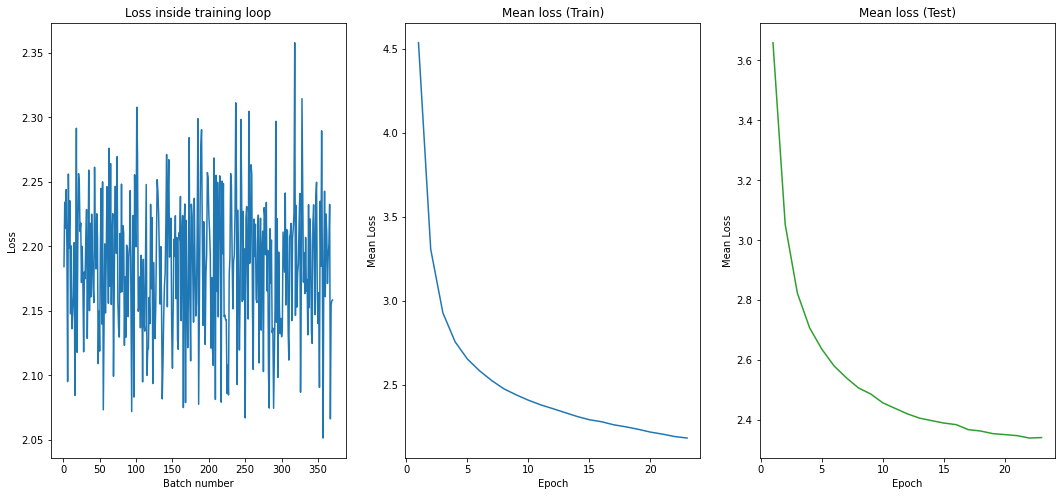

In [ ]:
for epoch in range(23):

    network.train(True)

    train_loss_inepoch = []
    test_loss_inepoch = []

    for i, batch in enumerate(dataloader_train):
        img, cap_ix = batch
    
        img = img.to(device)
        cap_ix = cap_ix.to(device)

        optimizer.zero_grad()

        loss = compute_loss(network, img, cap_ix)
        loss.backward()

        optimizer.step()

        train_loss_inepoch.append(loss.item() / img.size()[0]) # divide loss by the batch size
        if i%10 == 0:
            print_loss(train_loss_inepoch, train_loss, test_loss)

    train_loss.append(np.mean(train_loss_inepoch))
    print_loss(train_loss_inepoch, train_loss, test_loss)

    network.train(False)

    for batch in dataloader_test:
        img, cap_ix = batch

        img = img.to(device)
        cap_ix = cap_ix.to(device)

        with torch.no_grad():
            loss = compute_loss(network, img, cap_ix)

        test_loss_inepoch.append(loss.item() / img.size()[0])
    test_loss.append(np.mean(test_loss_inepoch))
    print_loss(train_loss_inepoch, train_loss, test_loss)
    

In [ ]:
torch.save(network.state_dict(), 'best_model_1.pt')

In [20]:
network.load_state_dict(torch.load('best_model_1.pt', map_location=device))

<All keys matched successfully>

## Inseption и получение результатов


In [21]:
# загружаем inseption, чтобы можно было прогонять через него новые картинки, 
# получать их эмбеддинги и генерировать описания с помощью нашей сети
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)
inception = inception.to(device)

for layer in inception.parameters():
    layer.requires_grad_(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:83: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

### Сгенерируем описание

In [24]:
vocab.idx_to_sent(np.argsort(np.array([1,2,3,0,-1,-2]))[-5:])

['"', '!', '<bos>', '<eos>', '<pad>']

In [39]:
def generate_caption(image, caption_prefix='<bos>', 
                     t=1., sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    network.train(False)
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32).to(device)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = vocab.sent_to_idx([caption_prefix])
        top5 = []
        
        # слово за словом генерируем описание картинки
        for _ in range(max_len):
            # 1. представляем caption_prefix в виде матрицы
            # 2. Получить из RNN-ки логиты, передав ей vectors_neck и матрицу из п.1
            # 3. Перевести логиты RNN-ки в вероятности (например, с помощью F.softmax)
            # 4. сэмплировать следующее слово в описании, используя полученные вероятности. Можно сэмплировать жадно 
            # (тупо слово с самой большой вероятностью), можно сэмплировать из распределения
            # 5. Добавляем новое слово в caption_prefix
            # 6. Если RNN-ка сгенерила символ конца предложения, останавливаемся

            inwordseq = torch.tensor([caption_prefix]).to(device) # [batch, sent_len] = [1,caption_prefix_len]
            outword = network(vectors_neck, inwordseq)            # [sent_len, batch, vocab_size] = [caption_prefix_len+1,1,vocab_size]
            outword = outword.to('cpu')[-1].squeeze()/t           # [vocab_size]
            outword = F.softmax(outword, dim=0)
            top5_idx = np.argsort(outword)[-5:]
            top5_proba = outword[top5_idx].numpy()
            top5.append(dict(zip(vocab.idx_to_sent(top5_idx), top5_proba)))
            if sample == False:
                idx = outword.argmax().item()
            else:
                idx = torch.multinomial(outword, 1)
            caption_prefix.append(idx)

            if vocab.words[idx] == vocab.eos:
                break
            
    return vocab.idx_to_sent(caption_prefix), top5

### Inference: let's see what it can do:

In [ ]:
#sample images

!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O tony_hawk.jpg
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O cat_dog.jpg
!wget "https://upload.wikimedia.org/wikipedia/commons/thumb/1/17/Vladimir_Putin_%282018-03-01%29_03_%28cropped%29.jpg/1200px-Vladimir_Putin_%282018-03-01%29_03_%28cropped%29.jpg" -O putin.jpg
!wget "https://pixy.org/src/2/28042.jpg" -O grandpa.jpg
!wget "https://pixy.org/src/38/385694.jpg" -O cycler.jpg
!wget "https://pixy.org/src/32/328718.jpg" -O soccer.jpg

#### Tony Hawk

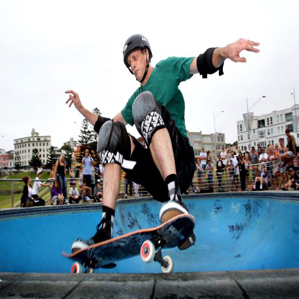

In [30]:
from PIL import Image

img = Image.open('tony_hawk.jpg').convert('RGB').resize((299,299))
img_arr = np.array(img).astype('float32') / 255.
img

In [33]:
#Sentence by sampling
for i in range(10):
    print(' '.join(generate_caption(img_arr, t=0.2, max_len=15, sample=True)[0][1:-1]))

a skateboarder is doing a trick on a ramp .
a skateboarder is doing a trick on a ramp .
a man riding a skateboard on top of a cement ramp .
a skateboarder is doing a trick on a ramp .
a man on a skateboard doing a trick on a ramp .
a skateboarder is doing a trick on a ramp .
a skateboarder is doing a trick on a ramp .
a skateboarder is doing a trick on a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard on a ramp .


In [43]:
#Probabilities of top5 words on each generation step
generate_caption(img_arr, t=0.2, max_len=15, sample=True)

(['<bos>',
  'a',
  'man',
  'on',
  'a',
  'skateboard',
  'doing',
  'a',
  'trick',
  'on',
  'a',
  'ramp',
  '.',
  '<eos>'],
 [{'a': 0.9999999,
   'man': 8.5532337e-10,
   'skateboarder': 1.765893e-08,
   'the': 6.532543e-08,
   'there': 2.4155017e-10},
  {'boy': 0.00020121882,
   'man': 0.3672591,
   'person': 0.0017772687,
   'skateboarder': 0.62969583,
   'young': 0.0009798923},
  {'doing': 0.012888383,
   'in': 0.0022372145,
   'is': 0.030966964,
   'on': 0.36808583,
   'riding': 0.5856806},
  {'a': 1.0,
   'his': 9.664271e-09,
   'skateboard': 1.560993e-11,
   'some': 2.8576003e-11,
   'the': 1.1386115e-09},
  {'board': 9.2585206e-10,
   'skate': 6.0433367e-06,
   'skateboard': 0.9999939,
   'snowboard': 3.5202294e-10,
   'surfboard': 1.6286009e-09},
  {'doing': 0.9872027,
   'in': 0.0036677157,
   'is': 0.0031558878,
   'on': 0.00094428216,
   'performing': 0.0034570328},
  {'a': 0.9925895,
   'an': 5.263865e-09,
   'some': 2.848093e-09,
   'stunts': 5.906704e-10,
   'trick

![img](https://live.staticflickr.com/65535/51879915030_efa55d79c2_o.png)

In [44]:
#Greedy sentence
' '.join(generate_caption(img_arr, t=0.2, max_len=15, sample=False)[0][1:-1])

'a skateboarder is doing a trick on a ramp .'

#### A cat with a Dog

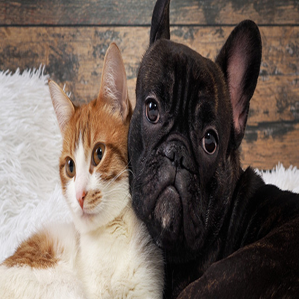

In [46]:
img = Image.open('cat_dog.jpg').convert('RGB').resize((299,299))
img_arr = np.array(img).astype('float32') / 255.
img

In [48]:
for i in range(10):
    print(' '.join(generate_caption(img_arr, t=0.5)[0][1:-1]))

a black and white cat is sitting on a table .
a black and white cat sitting on a wooden chair .
a black and white cat has a concerned look on .
a black and white cat with a santa claus hat .
a small dog is sitting on a couch
a black and white cat is sitting in a chair .
a black and white cat with a hat on its head .
a cat is laying on top of a remote control .
a black and white cat holds a remote control .
a black and white cat is sitting on a table .


In [49]:
' '.join(generate_caption(img_arr, t=0.2, max_len=15, sample=False)[0][1:-1])

'a black and white cat is sitting on a chair .'

#### Mr. President

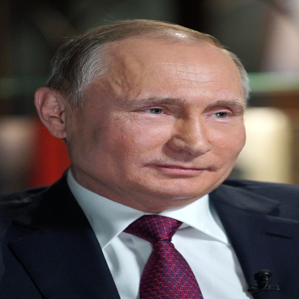

In [50]:
img = Image.open('putin.jpg').convert('RGB').resize((299,299))
img_arr = np.array(img).astype('float32') / 255.
img

In [51]:
for i in range(10):
    print(' '.join(generate_caption(img_arr, t=0.2, sample=True)[0][1:-1]))

a man in a suit and tie with a camera .
a man in a suit and tie is wearing a suit .
a man in a suit and tie standing in a room
a man in a suit and tie is wearing a suit and tie .
a man in a suit and tie standing in a room .
a man in a suit and tie is wearing a suit .
a man in a suit and tie standing in a room .
a man in a suit and tie standing in a room .
a man in a suit and tie with a camera .
a man in a suit and tie poses for a picture .


In [53]:
' '.join(generate_caption(img_arr, t=0.2, max_len=15, sample=False)[0][1:-1])

'a man in a suit and tie is smiling .'

#### Grandpa

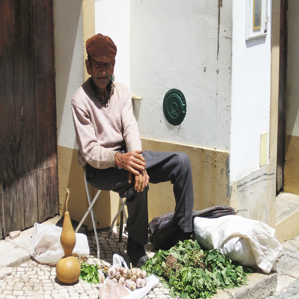

In [55]:
img = Image.open('grandpa.jpg').convert('RGB').resize((299,299))
img_arr = np.array(img).astype('float32') / 255.
img

In [56]:
for i in range(10):
    print(' '.join(generate_caption(img_arr, t=0.4, sample=True)[0][1:-1]))

a man and a woman are standing in a kitchen .
a man is standing in a kitchen with a pan of food .
a man standing in a kitchen next to a table with a cake .
a man standing next to a table with a cake on top .
a man in a kitchen preparing food
a man is putting a turkey into his mouth .
a man is holding a tray of food and drinks .
a man in a kitchen preparing food for a picture .
a woman and man are preparing food in a kitchen .
a man and woman are standing in a kitchen .


In [57]:
' '.join(generate_caption(img_arr, t=0.2, max_len=15, sample=False)[0][1:-1])

'a man and a woman standing in a kitchen .'

#### Cycler

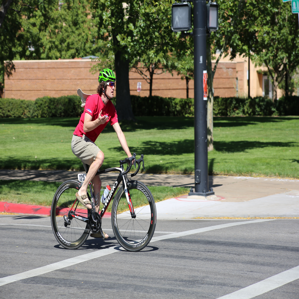

In [59]:
img = Image.open('cycler.jpg').convert('RGB').resize((299,299))
img_arr = np.array(img).astype('float32') / 255.
img

In [61]:
for i in range(10):
    print(' '.join(generate_caption(img_arr, t=0.2, sample=True)[0][1:-1]))

a woman riding a bike with a dog on a leash .
a woman on a bike with a dog on a leash .
a man riding a bike with a dog on a leash .
a man riding a bike with a dog on a leash .
a woman riding a bike with a dog on a leash .
a woman on a bike with a dog on the sidewalk .
a woman riding a bike down a street next to a bike .
a woman riding a bike with a dog on a leash .
a woman is riding a bike on a street .
a man riding a bike down a street next to a bike .


In [62]:
' '.join(generate_caption(img_arr, t=0.2, max_len=15, sample=False)[0][1:-1])

'a woman riding a bike with a dog on a leash .'

#### Soccer 

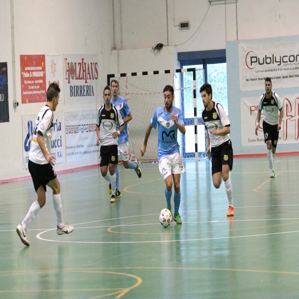

In [63]:
img = Image.open('soccer.jpg').convert('RGB').resize((299,299))
img_arr = np.array(img).astype('float32') / 255.
img

In [64]:
for i in range(10):
    print(' '.join(generate_caption(img_arr, t=0.2, sample=True)[0][1:-1]))

a group of people playing a game of soccer .
a group of people playing a game of tennis .
a group of people playing a game of soccer .
a group of people playing a game of soccer .
a group of people playing a game of soccer .
a group of people standing on a tennis court .
a group of people playing tennis on a court
a group of people playing a game of tennis .
a group of people standing on a tennis court .
a group of people standing on a tennis court .


In [66]:
' '.join(generate_caption(img_arr, t=0.2, max_len=15, sample=False)[0][1:-1])

'a group of people playing a game of soccer .'